# Fraud detection with Deep Learning Autoencoders and Time Series
This is a toy example of fraud/anomaly detection using a [kaggle dataset of fraudulent and non-fraudulent credit card transactions](https://www.kaggle.com/mlg-ulb/creditcardfraud). 

Fraud detection is a classically difficult classification problem. The classes are severely unbalanced and fraud patterns evolve rapidly. The changing behaviour of fraudulent activity introduces concept drift or covariate shift -- data relationships in production are likely to be systematically different from the training/test sets.

One approach to understanding and detecting anomalous behaviour is to use autoencoder networks. By modelling the prediction/reconstruction error of the autoencoder network as a discriminating function, anomalous data points can be more easily identified.

## Autoencoders

Autoencoder networks are a type of unsupervised learning where the target is the input. In other words, autoencoders attempt to learn the identity function:

\begin{equation*}
h_{W,b}(x) \approx x
\end{equation*}

This might seem like a really easy task, but autoenoders attempt to make meaningful reconstructions of data by bottlenecking the system. By constraining the size of the hidden units in the network, meaningful structures of data can be discovered in a similar manner to dimensionality-reduction approaches like PCA.

<img src="Autoencoder636.png" alt="Drawing" style="width: 250px;"/>

Because autoencoders are creating low-dimensional representations of mostly 'normal' data, they do not necessarily need to explicitly model fraudulent/anomalous behaviour. They attempt to reconstruct data trained on 'normal' behaviour. Under the assumption that anomalous behaviour is systematically different from 'normal' data, anomalous behaviour will be evident in the reconstruction error.

We're interested in two processes: the *encoding* and *decoding* of data. These can be represented as:

\begin{equation*}
\phi : \chi \rightarrow \digamma
\end{equation*}
\begin{equation*}
\psi : \digamma \rightarrow \chi
\end{equation*}

If $X$ is the input and $Y$ the output, with $n$ elements:

\begin{equation*}
Y = (\psi \circ \phi)X
\end{equation*}

with a mean square error loss function:

\begin{equation*}
MSE = \frac{1}{n}\sum\limits_{i=1}^n i^2 = (Y_i - \hat{Y}_i)^2
\end{equation*}

By setting a threshold on the reconstruction error (typically $1.96 \sigma$, though thresholds can be set using traditional methods such as ROC curves or precision/recall optimization), anomalous data points can be identified.

Additional information on autoencoders (in MXNet and other frameworks) can be found [here](https://github.com/apache/incubator-mxnet/tree/master/example/autoencoder), [here](https://www.oreilly.com/ideas/anomaly-detection-with-apache-mxnet), and [here](http://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf).


# What do We Do Once We have Reconstruction Error? (Next Post!)
## State-Space Modelling, Kalman Filters, and Deep Learning Time Series Approaches

### Kalman Filters

Training an autoencoder network allows us to predict the reconstruction loss of each unit of analyses. Plotting this loss gives us a time series. We can then use a filtering and smoothing time series technique known as Kalman Filters to identify anomalous data points. This better allows us to account for periodicity or other time dynamics that may influence the reconstruction error.

Assuming a single state equation with a transition matrix $T$ as a scalar, and a single observation equation, the Kalman filter algorithm is:

\begin{equation*}
\alpha_{t|t-1} = T\big[\alpha_{t-1|t-2} + K_{t-1}(y_{t-1} - Z\alpha_{t-1|t-2})\big]
\end{equation*}

Where $\alpha_{t|t-1}$ is the predicted state at $t$. This is equal to the predicted state at $t-1$ which is adjusted by the state prediction error at $t-1$ and then multiplied by the transition matrix $T$. Here $K_{t-1}$ is the 'Kalman gain' -- how much past prediction error affects the current predicted state.

By setting a threshold value (again, typically $\hat{y} \pm 1.96\sigma $), we can define potentially anomalous/fraudulent transactions.

### General State-Space Modelling

State-space modelling as a general form allows us to more easily handle time-varying parameters, trending, seasonality and structural breaks. Of particular use, state-space modelling can offer robust approaches in dealing with measurement error -- a key advantage when using autoencoder reconstruction error as a feature.

[Commandeur and Koopman - State Space Time Series Analysis](https://global.oup.com/academic/product/an-introduction-to-state-space-time-series-analysis-9780199228874?cc=ca&lang=en&) is excellent primer on state space modelling. The next post in this series will show state space models in python using the reconstruction error of this example.

Until then, lets build out a simple autoencoder and find fraud!


# Building the Autoencoder with MXNet
The kaggle dataset has a number of covariates (transformed/anonymized using PCA). Let's see what we're workin' with.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import Data
card_data = pd.read_csv('creditcard.csv')
card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Class Labels show strongly unbalanced data
pd.value_counts(card_data['Class'], sort = True)

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# Creating Train/Test Sets & Converting them to MXNet nd.arrays & 
# Data Iterators with Batch Size of 256

from mxnet import nd, autograd, gluon
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

batch_size = 256

# Standardize Amount Spent to 0 mean and unit variance
card_data['Amount'] = StandardScaler().fit_transform(card_data['Amount'].values.reshape(-1, 1))

# Train/Test Splits
X_train, X_test = train_test_split(card_data, test_size=0.25, random_state=1)

# Difference between autoencoders and other approaches is that we explicity 
# want to remove known cases of fraud from training set

X_train = X_train[X_train.Class == 0]

# Remove 'Time' for now. Other approaches (LSTM autoencoders) can better model time-series elements
X_train = X_train.drop(['Class', 'Time'], axis=1)  
X_train = X_train.values.astype(np.float32)

y_test = X_test['Class']
X_test = X_test.drop(['Class', 'Time'], axis=1)
X_test = X_test.values.astype(np.float32)

train_data = gluon.data.DataLoader(X_train, batch_size = batch_size)
test_data = gluon.data.DataLoader(X_test, batch_size = batch_size)

# Get length of features for final output layer
input_dim = X_train.shape[1]

In [5]:
import mxnet as mx

ctx = mx.cpu()  # Train on CPU

model = gluon.nn.HybridSequential()

# Build child class to programatically create dense layers
class ConnectedBlocks(gluon.nn.HybridSequential):
    def __init__(self, neurons, dropout, activation='tanh'):
        """
        :param neurons: list with number of cells for each fully-connected layer
        :param dropout: dropout regularization to apply between fully-connected layers
        :param activation: Activation function (Default=tanh)
        """
        super().__init__()
        with self.name_scope():
            for units in neurons:
                self.add(gluon.nn.Dense(units=units, activation=activation))
                self.add(gluon.nn.Dropout(rate=dropout))


# Define Model
with model.name_scope():
    # Encoder
    model.add(ConnectedBlocks(neurons=[20,15,8], dropout=.25))
    
    # Decoder
    model.add(ConnectedBlocks(neurons=[15,20], dropout=.25))
    
    # Hidden Layer -> Output Layer 
    # Needs to be same dim as input to reconstruct
    model.add(gluon.nn.Dense(input_dim))

# Hybridize network (convert from imperitive to symbolic)
model.hybridize()

# Initialize parameters with Xavier
model.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# Adam optimizer
optimizer = gluon.Trainer(model.collect_params(), 
                          'adam', {'learning_rate': 0.001})

# L2 Loss Function
L = gluon.loss.L2Loss()

print(model)

HybridSequential(
  (0): ConnectedBlocks(
    (0): Dense(None -> 20, Activation(tanh))
    (1): Dropout(p = 0.25, axes=())
    (2): Dense(None -> 15, Activation(tanh))
    (3): Dropout(p = 0.25, axes=())
    (4): Dense(None -> 8, Activation(tanh))
    (5): Dropout(p = 0.25, axes=())
  )
  (1): ConnectedBlocks(
    (0): Dense(None -> 15, Activation(tanh))
    (1): Dropout(p = 0.25, axes=())
    (2): Dense(None -> 20, Activation(tanh))
    (3): Dropout(p = 0.25, axes=())
  )
  (2): Dense(None -> 29, linear)
)


In [6]:
# For each mini-batch, evaluate the loss
def eval_loss_func(data_iterator, model, loss_func):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data)
        loss = loss_func(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [7]:
%%time
epochs = 20

train_loss = []
test_loss = []

# training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx)
        with autograd.record():  # Build the computation graph for autodiff
            output = model(data)
            loss = L(output, data)
        loss.backward() # backprop
        optimizer.step(batch_size) # update the weights normalized by batch size
    
    train_batch_mse = eval_loss_func(train_data, model, L)
    test_batch_mse = eval_loss_func(test_data, model, L)

    train_loss.append(train_batch_mse)
    test_loss.append(test_batch_mse)

    if e % 5 == 0:
        print("Train MSE: %4.3f \t Test MSE: %4.3f" % (train_batch_mse, test_batch_mse))

Train MSE: 0.363 	 Test MSE: 0.381
Train MSE: 0.331 	 Test MSE: 0.349
Train MSE: 0.326 	 Test MSE: 0.344
Train MSE: 0.321 	 Test MSE: 0.339
CPU times: user 2min 17s, sys: 12.5 s, total: 2min 29s
Wall time: 1min 48s


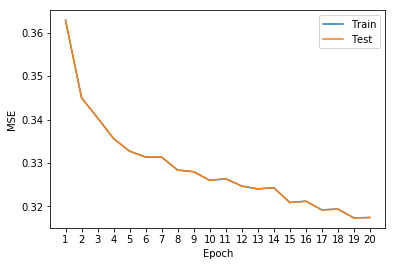

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

def plot_errors(train_mse, test_mse):
    epochs = range(1, len(train_mse)+1)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend()
    plt.show()
    
plot_errors(train_loss, train_loss)

In [9]:
# Get Reconstruction Error of Test Set
recon_error = []

for i, data in enumerate(test_data):
    out = model(data)
    test_loss = L(out, data).asnumpy().flatten()
    recon_error = np.append(recon_error, test_loss)

# Set threshold at 1 std (may increase false positives but recall very important)
threshold =  np.mean(recon_error) + np.std(recon_error)

# Define Anomalies as > threshold
anomaly = list(map(lambda v: v > threshold, recon_error))

In [10]:
error_df = pd.DataFrame({'reconstruction_error': recon_error,
                        'true_class': y_test,
                        'Anom': anomaly})

error_df.head()

,reconstruction_error,true_class,Anom
169876,0.273633,0,False
127467,0.075937,0,False
137900,0.090028,0,False
21513,0.135035,0,False
134700,0.129437,0,False


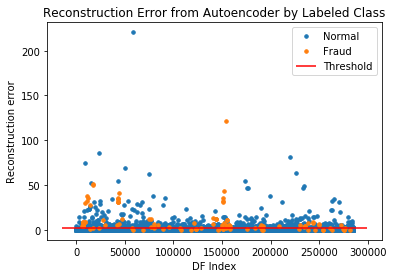

In [11]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error from Autoencoder by Labeled Class")
plt.ylabel("Reconstruction error")
plt.xlabel("DF Index")
plt.show();

In [12]:
# Reconstruction Error by true class in test set
error_df.groupby('true_class', as_index=False)['reconstruction_error'].mean()

,true_class,reconstruction_error
0,0,0.318811
1,1,10.556972


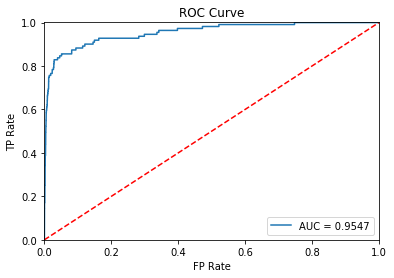

In [13]:
from sklearn.metrics import (confusion_matrix, roc_curve, 
                             auc, f1_score, 
                             precision_score, recall_score)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_area = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_area)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

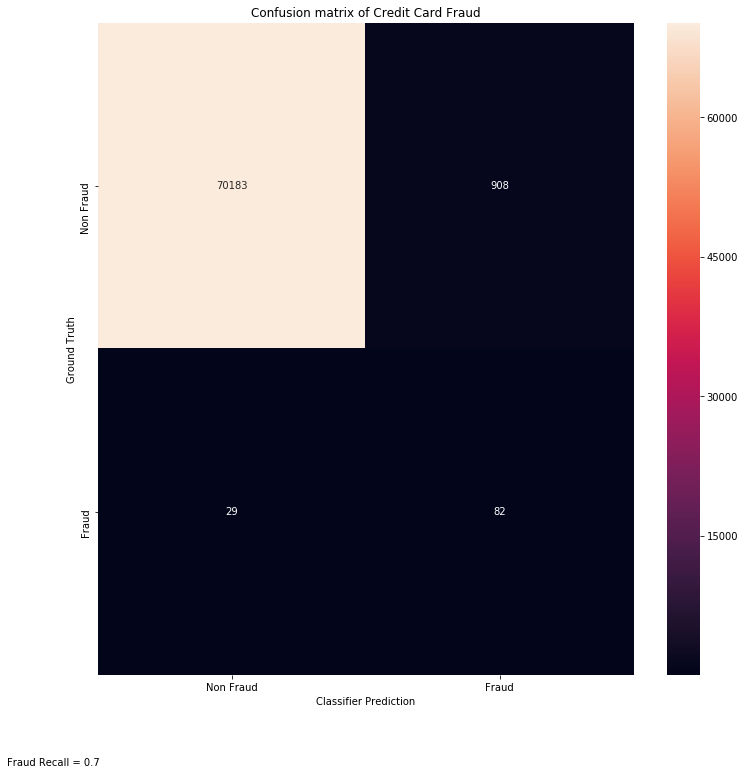

In [14]:
# Identify points beyond reconstruction error threshold
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

# Fraud Recall
macro_recall = recall_score(error_df.true_class, y_pred, average='binary')  

# Confusion Matrix
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
LABELS = ["Non Fraud", "Fraud"]
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix of Credit Card Fraud")
plt.ylabel('Ground Truth')
plt.xlabel('Classifier Prediction')
plt.figtext(.02, .02, "Fraud Recall = %1.1f" % (macro_recall))
plt.show()
